In [1]:
import numpy as np
import pandas as pd
from textblob import Word
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 100)

In [3]:
### cluster charges to identify as property-related charge

In [4]:
corig = pd.read_csv('charges_tempt.csv', dtype=str, header=0, index_col=None)

print(corig.shape)
corig.head(2)

(37480, 15)


,CompanyName,CompanyNumber,CompanyStatus,IncorporationDate,SICCode,status,persons_entitled,delivered_on,charge_number,classification.type,classification.description,particulars.type,particulars.description,RegAddress.District,RegAddress.PostCode
0,CHG-MERIDIAN UK LIMITED,01276016,Active,1976-09-06T00:00:00.000Z,"[{""code"":""64910"",""description"":""Financial leasing""}]",outstanding,"[{""name"":""Bal Global Finance (UK) Limited""}]",2019-08-01T00:00:00.000Z,2529,charge-description,A registered charge,brief-description,A security charge dated 31/07/2019 between bal global finance (UK) limited (the “lender”) and ch...,RUNNYMEDE,TW20 9AB
1,CHG-MERIDIAN UK LIMITED,01276016,Active,1976-09-06T00:00:00.000Z,"[{""code"":""64910"",""description"":""Financial leasing""}]",outstanding,"[{""name"":""Bal Global Finance (UK) Limited""}]",2019-08-01T00:00:00.000Z,2528,charge-description,A registered charge,brief-description,A security charge dated 31/07/2019 between bal global finance (UK) limited (the “lender”) and ch...,RUNNYMEDE,TW20 9AB


### Build editable copy

In [5]:
cedit = corig.copy()

cedit = cedit[~cedit['RegAddress.District'].isna()]
cedit = cedit[~cedit['particulars.description'].isna()]
cedit = cedit[['CompanyName','CompanyNumber','SICCode','persons_entitled','particulars.description','RegAddress.District']]
cedit.rename(columns={'particulars.description': 'desc', 'RegAddress.District': 'district'}, inplace=True)

cedit.head(2)

,CompanyName,CompanyNumber,SICCode,persons_entitled,desc,district
0,CHG-MERIDIAN UK LIMITED,01276016,"[{""code"":""64910"",""description"":""Financial leasing""}]","[{""name"":""Bal Global Finance (UK) Limited""}]",A security charge dated 31/07/2019 between bal global finance (UK) limited (the “lender”) and ch...,RUNNYMEDE
1,CHG-MERIDIAN UK LIMITED,01276016,"[{""code"":""64910"",""description"":""Financial leasing""}]","[{""name"":""Bal Global Finance (UK) Limited""}]",A security charge dated 31/07/2019 between bal global finance (UK) limited (the “lender”) and ch...,RUNNYMEDE


In [6]:
print(f'Unique descriptions: {len(cedit.desc.unique())}')

Unique descriptions: 22301


### Start NLP

In [7]:
cedit['desc'] = cedit['desc'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

cedit.iloc[:2].desc

0    a security charge dated 31/07/2019 between bal global finance (uk) limited (the “lender”) and ch...
1    a security charge dated 31/07/2019 between bal global finance (uk) limited (the “lender”) and ch...
Name: desc, dtype: object

In [8]:
def remove_sym(x):
    new_str = ''
    for c in x:
        if (c.isalnum() == False) & (c != ' '):
            pass
        else:
            new_str += c
    return new_str

In [9]:
cedit['desc'] = cedit['desc'].apply(remove_sym)

cedit.iloc[:2].desc

0    a security charge dated 31072019 between bal global finance uk limited the lender and chgmeridia...
1    a security charge dated 31072019 between bal global finance uk limited the lender and chgmeridia...
Name: desc, dtype: object

In [10]:
stop = stopwords.words('english')

cedit['desc'] = cedit['desc'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

cedit.iloc[:2].desc

0    security charge dated 31072019 bal global finance uk limited lender chgmeridian computer uk limi...
1    security charge dated 31072019 bal global finance uk limited lender chgmeridian computer uk limi...
Name: desc, dtype: object

In [11]:
desc_words = pd.Series(' '.join(cedit['desc']).split()).value_counts()

print(f'desc unique words: {len(desc_words)}')

desc unique words: 40415


In [12]:
desc_rare = desc_words[(desc_words <= 4)]

print(f'Rare desc word count: {len(desc_rare)}')

Rare desc word count: 32727


In [13]:
cedit['desc'] = cedit['desc'].apply(lambda x: " ".join(x for x in str(x).split() if x not in desc_rare))

cedit.iloc[:2].desc

0    security charge dated 31072019 bal global finance uk limited lender chgmeridian computer uk limi...
1    security charge dated 31072019 bal global finance uk limited lender chgmeridian computer uk limi...
Name: desc, dtype: object

In [14]:
# remove desc == '' and desc == 'na'
cedit['desc'] = cedit['desc'].apply(lambda x: " ".join(x for x in str(x).split() if len(x) > 1))
cedit = cedit[cedit['desc'] != 'na']

cedit.iloc[:2].desc

0    security charge dated 31072019 bal global finance uk limited lender chgmeridian computer uk limi...
1    security charge dated 31072019 bal global finance uk limited lender chgmeridian computer uk limi...
Name: desc, dtype: object

In [15]:
print(f"Number of rows: {len(cedit)}")
print(f"Remaining total word count: {len(pd.Series(' '.join(cedit['desc']).split()))}")
print(f"Remaining unique word count: {len(pd.Series(' '.join(cedit['desc']).split()).value_counts())}")

Number of rows: 27494
Remaining total word count: 435368
Remaining unique word count: 7662


In [16]:
tf = TfidfVectorizer(max_features=1000000, lowercase=True, analyzer='word',
                        stop_words='english', ngram_range=(1,1))

tfvec = tf.fit_transform(cedit['desc'])

tfvec

<27494x7584 sparse matrix of type '<class 'numpy.float64'>'
	with 334633 stored elements in Compressed Sparse Row format>

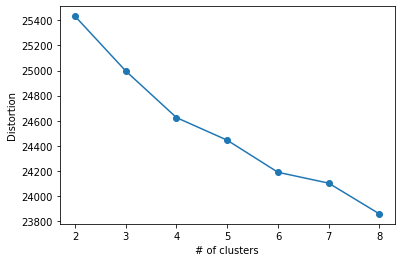

In [17]:
distortions = []
our_range = range(2, 9)
for i in our_range:
    km = KMeans(n_clusters=i, init='k-means++',
                n_init=10, max_iter=50, random_state=0)
    km.fit(tfvec)
    distortions.append(km.inertia_)
plt.plot(our_range, distortions, marker='o')
plt.xlabel('# of clusters')
plt.ylabel('Distortion')
plt.show()

In [109]:
# 3 is best outcome after reviewing cluster results
km = KMeans(n_clusters=3, init='k-means++',
            n_init=10, max_iter=100, random_state=0)

km_pred = km.fit_predict(tfvec)

In [110]:
cedit['km_pred'] = km_pred

cedit.head(2)

,CompanyName,CompanyNumber,SICCode,persons_entitled,desc,district,km_pred
0,CHG-MERIDIAN UK LIMITED,01276016,"[{""code"":""64910"",""description"":""Financial leasing""}]","[{""name"":""Bal Global Finance (UK) Limited""}]",security charge dated 31072019 bal global finance uk limited lender chgmeridian computer uk limi...,RUNNYMEDE,0
1,CHG-MERIDIAN UK LIMITED,01276016,"[{""code"":""64910"",""description"":""Financial leasing""}]","[{""name"":""Bal Global Finance (UK) Limited""}]",security charge dated 31072019 bal global finance uk limited lender chgmeridian computer uk limi...,RUNNYMEDE,0


In [111]:
# distribution of predictions
cedit.km_pred.value_counts()

0    23877
1     3039
2      578
Name: km_pred, dtype: int64

In [112]:
cedit[cedit.km_pred == 0].desc.sample(10)

34445    leasehold properties michigan point tower 11 michigan avenue salford m50 2hj title number detail...
24156                                                                                  pratt aircraft engine
9496                                                                      business yard situated 16 road 9dw
14735                                                                           16 lane leigh lancashire wn7
20894    freehold property house paynes park hitchin 1eh registered land registry title absolute title nu...
33659    way debenture property known land south east side 21 beulah crescent thornton heath cr7 8jl regi...
19872                                                                                       14 road stafford
24011                                                                                    road portsmouth 5an
4016                                                                337 park rd edgbaston birmingham b16 0lb
28703              

In [113]:
cedit[cedit.km_pred == 1].desc.sample(10)

22199    way fixed charge estates interests freehold leasehold property company present future together b...
12853    freehold leasehold property future belonging company together buildings trade fixtures fixed pla...
35026    freehold property known 13 road derby de22 3pl land buildings title including buildings fixtures...
36238    registration logo fixed floating charge assets undertaking company present future including real...
14654    way legal charge freehold leasehold property specified legal chargeii property including limited...
4433     freehold leasehold property future belonging company together buildings trade fixtures fixed pla...
10891    charges pension scheme way first legal mortgage real properties whether registered unregistered ...
28688    present future freehold leasehold property including without limitation property specified sched...
22044    fixed charge entire issued share capital funding company registered name chargor stocks shares s...
5558     freehold p

In [114]:
cedit[cedit.km_pred == 2].desc.sample(10)

4999                                   fixed floating charge assets
9960     fixed floating charge assets including broadway dudley 4ar
15719                                  fixed floating charge assets
13076                                  fixed floating charge assets
13956                                  fixed floating charge assets
5377                                   fixed floating charge assets
34064                                  fixed floating charge assets
8945                                   fixed floating charge assets
9579                                   fixed floating charge assets
36738                                  fixed floating charge assets
Name: desc, dtype: object

In [116]:
# we see clean lack of cluster 2 for leasehold
cedit[cedit.desc.str.contains('leasehold')].km_pred.value_counts()

1    1695
0    1492
2       1
Name: km_pred, dtype: int64

In [117]:
# we see clean lack of cluster 2 for freehold
cedit[cedit.desc.str.contains('freehold')].km_pred.value_counts()

0    4533
1    1803
2       1
Name: km_pred, dtype: int64

In [139]:
cedit[(cedit.desc.str.contains('freehold')) & (cedit.km_pred==2)]

,CompanyName,CompanyNumber,SICCode,persons_entitled,desc,district,km_pred
12059,EXCLUSIVE VENUES LIMITED,10460833,"[{""code"":""55900"",""description"":""Other accommodation""}]","[{""name"":""Phd Finance \u0026 Investments Limited""}]",first charge freehold leasehold property first fixed charge assets company,ELMBRIDGE,2


### Improve through manual labeling

In [151]:
clabel = cedit.copy()
clabel['label'] = np.NaN

clabel.head(2)

,CompanyName,CompanyNumber,SICCode,persons_entitled,desc,district,km_pred,label
0,CHG-MERIDIAN UK LIMITED,01276016,"[{""code"":""64910"",""description"":""Financial leasing""}]","[{""name"":""Bal Global Finance (UK) Limited""}]",security charge dated 31072019 bal global finance uk limited lender chgmeridian computer uk limi...,RUNNYMEDE,0,NaN
1,CHG-MERIDIAN UK LIMITED,01276016,"[{""code"":""64910"",""description"":""Financial leasing""}]","[{""name"":""Bal Global Finance (UK) Limited""}]",security charge dated 31072019 bal global finance uk limited lender chgmeridian computer uk limi...,RUNNYMEDE,0,NaN


In [152]:
label0 = {
    'none': 0,
    'applicable': 0,
    'legal assignment contract monies': 0,
    'please see instrument details': 0,
    'security cash deposits': 0,
    'general pledge': 0,
    'specific land ship aircraft intellectual property charged full details charges please refer charging document directly': 0,
    'assets company way first fixed floating charge note company precluded without consent writing advantedge commercial finance north limited creating charge upon book debts due ranking either priority pari passu charge': 0,
    'contains fixed charge contains floating charge covers property undertaking companycontains negative pledge': 0,
    'intellectual property listed exhibit document uploaded filing': 0,
    'fixed charges land intellectual property owned company time':0,
    'debenture': 0,
}

In [143]:
### for manual labeling
# cedit[cedit.km_pred == 2].desc.value_counts()

In [154]:
clabel.km_pred.value_counts()

0    23877
1     3039
2      578
Name: km_pred, dtype: int64

In [156]:
# label cluster 2 as 0 aka not of interest
# label clusters 0 and 1 as 1 aka of interest
clabel['label'] = np.where(clabel.km_pred.isin([0, 1]), 1, 0)

clabel['label'].value_counts()

1    26916
0      578
Name: label, dtype: int64

In [166]:
# relabel items in label0 as 0 aka not of interest
clabel['label'] = np.where(clabel.desc.isin(label0), 0, clabel.label)

clabel['label'].value_counts()

1    25062
0     2432
Name: label, dtype: int64

In [168]:
# clabel.to_csv('charges_labelled.csv')